# Time series forecasting applied to infectious diseases 

Traditional data collection assumes that when we collect a series of data points $d_{1},d_{2},\cdots,d_{n}$ that these data points are independent from one another. In other words, we assume that collecting the data point $d_{i}$ does not have an impact on the data points generated after $d_{i+1},d_{i+2},\cdots$.

Time series data assumes that information we collect over time is related. 
That is, we assume that the data points collected at time $t$ impacts the data points collected at times $t+1, t+2, \cdots$. 

## Statistical language (The "where is the bathroom?" tutorial). 

All of statistics is based on the **experiment** and modern statistics is based on the **random variable**.

An **experiment** is any pheonema that generates an observation from a set of possible **outcomes**. 
For example, an experiment can be defined as a human who sits at the nearest intersection records the number of red cars that pass per hours. 
A more direct experiment could be considered, we observe a series of epidemic weeks and record the number of patients how walk into a healthcare facility as well as the number of those indiviuals who are diagnosed with influenza-like illness (ILI). Here, the experment is alowing one week to pass and the observations per week are (the number of individuals who enter a healthcare facility in the state, the number of individuals diagnosed with ILI). 

A **random variable**, typically defined with capital letters (like $X,Y,Z$), maps all possible outcomes form an experiment to a number. 
For example, we can define the random variable $X$ to map the number of red cars observed at the intersection to the same integer on the number line. 
The random variables $Y$ and $Z$ can map the number of individuals who attend a health care facility and number diagnosed with ILI to their respective integers.
Random variables are very flexible. 
For example, our experiment may record the type of flu-test administered to an individual. The possible outcomes could be: XXX. 
We can define a random variable $T$ that maps X to the value 0, X to the value 1, and all other tests to the value 2. 

With a random variable in hand, we can ask probability questions $P(X=1)$, $P(X<10)$, $P(X+Y=5)$ and so on.

*Random variables are the building blocks of statistical modeling.*
They move the experimental process to the numberline where we can use algebra, calculus, etc to manipulate these variables. 

### RV approach to time series modeling. 

We can define our time series as a single realization of a sequence of random variables. 
Let the random variables $X_{1}, X_{2}, \cdots, X_{T}$ represent the set of possible ILI diagnoses at epiweeks 2025W40,2025W41,2025W42, etc. Then, our observed time series data $(x_{1},x_{2},x_{3},\cdots,x_{T})$ is a single realization from these $T$ random variables. 
In essence, we played the following game: at time 1 we asked $X_{1}$ to generate a single observation from all possible ones it could generated. Then we moved to $X_{2}$ and asked the same question. The replies were stacked in sequence. 



## The dataset
The dataset we will use for lecture is called U.S. Outpatient Influenza-like Illness Surveillance Network, or ILINet.
Collection for this dataset began during the 1997/98 season. Data is available via ILINet at the national level, for all 10 health and human services (HHS) regions, as well at state level. ILINet provides the number of patients recorded at outpatient healthcare facilties and the number of those individuals who were diagnosed with influenza-like Illness weekly. 
For our work here we will study the percent ILI which is defined as the number of those diagnosed with ILI divided by the number of individuals who were recorded at a healthcare facility. 

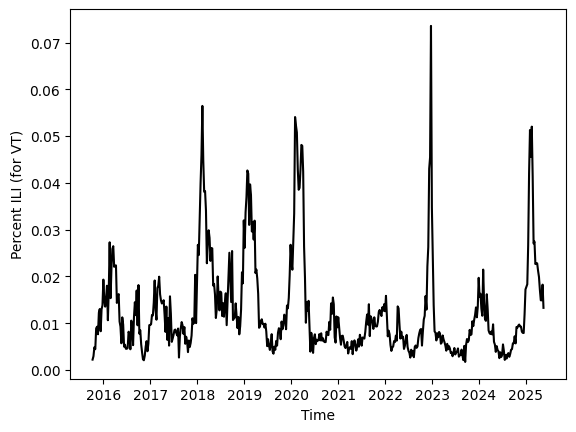

In [8]:
#--import python packages 
import pandas as pd
from epiweeks import Week
import matplotlib.pyplot as plt 

#--Delphi-Epidata API for collecting ILI data easy
from delphi_epidata import Epidata

ili_data_request_object = Epidata.fluview(regions=['vt'], epiweeks=['201540-202520'])
ili_data                = pd.DataFrame(ili_data_request_object['epidata'])

#--Adding some extra to the ILI dataset
#--i want to add the end date to each MMWR week to help with plot presentation
ili_data["end_date"] = [ Week.fromstring(str(x)).enddate()  for x in ili_data.epiweek.values]
ili_data["ili_prop"] = ili_data.num_ili / ili_data.num_patients

#--plotting our time series data
fig, ax = plt.subplots()
ax.plot( ili_data["end_date"], ili_data["ili_prop"], color = "black" )
ax.set_xlabel("Time")
ax.set_ylabel("Percent ILI (for VT)")
plt.show()

**The goal** for exploratory data analysis (EDA) are to: (1) visualize, or otherwise extract, any characteristic patterns from your time series, (2) detect anamloies or other unusual information in your time series data, (3) test classic assumptions for many time series models, and (4) build a reasonable model. 

We will use techniques in EDA to inform how to build a time series model for ILI. 

## An important forecasting template.

Before more serious time series models, it is important to briefly explore the random walk. 
The random walk can teach us a valuable lesson on what we expect to happen to our forecasts intuitively. 

A random walk is defined as a sequence of random variables that have a Normal distribution (the bell curve) with the same expected value (mean) of zero and the same standard deviation of $\sigma$ (pronounced "sigma") such that 

\begin{align}
    Z_t = Z_{t-1} + \mathcal{N}(0,\sigma^{2})
\end{align}

For a random walk, what do we expect to happen to the standard deviation as we progress through time? To gain intuition, we can simulate several random walks for $T$ time steps. 

Any time you wish to use a simulation to build intuition, do the following:
1. Code one instance
2. Package this instance and then run many times 


## Code one instance 

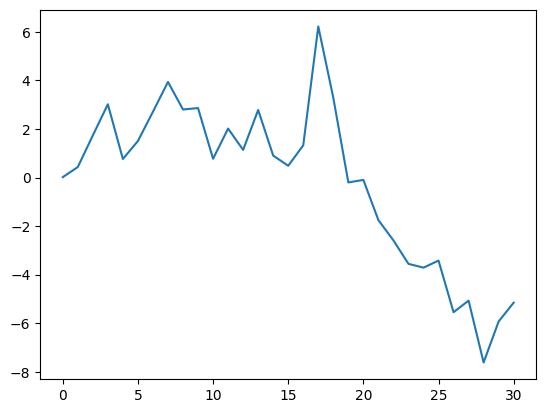

In [9]:
import numpy as np 

standard_deviation = 2.
T                  = 30

z = [np.random.normal(0,standard_deviation)]
for t in range(T):
    N           = np.random.normal(0,standard_deviation)
    z_t_minus_1 = z[-1]
    zt = z_t_minus_1 + N
    z.append(zt) 
plt.plot(z)

## Packages and run many times to gain intuition

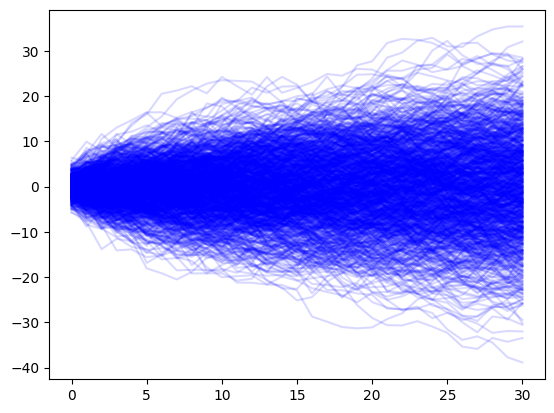

In [54]:
import numpy as np 

standard_deviation = 2.
T                  = 30

def generate_random_walk(center=0,standard_deviation=None,T=0):
    z = [np.random.normal(center,standard_deviation)]
    for t in range(T):
        N           = np.random.normal(0,standard_deviation)
        z_t_minus_1 = z[-1]
        zt = z_t_minus_1 + N
        z.append(zt) 
    return z

for sim in range(1000):
    random_walk = generate_random_walk(0, standard_deviation, T)
    plt.plot(random_walk, color="blue",alpha=0.15)

## Inuitively, we are less certain as the future progresses.  

As time progresses, the random walk spreads out slowly. 
This matches with out intuition when building a forecast.
We expect that as time progresses away from our observed data, that the uncertainity in our should also grow.
Lets look at how to apply a random walk to our ILI data.
Though this is a simplistic model, we will extract useful information about how we expect time series models to behave. 

## Fitting the random walk model to data 

Give a sequence of observations over time $x_{1},x_{2},x_{3},\cdots,x_{T}$, 
the random walk supposes that 

\begin{align}
    x_{t} = x_{t-1} + \mathcal{N}(0,\sigma^{2})
\end{align}

This then means that we expect the differences between two consecutive values to follow a Normal distribution. 

\begin{align}
    x_{t} - x_{t-1} = \mathcal{N}(0,\sigma^{2})
\end{align}

For the random walk model, we have a single parameter to estimate: the standard deviation of the size of the difference between two consecutive values. The standard deviation can be computed in all modern software. 

Lets plot the difference in the proportion of ILI over time. 
We'll look at the raw differneces as well as a histogram. 

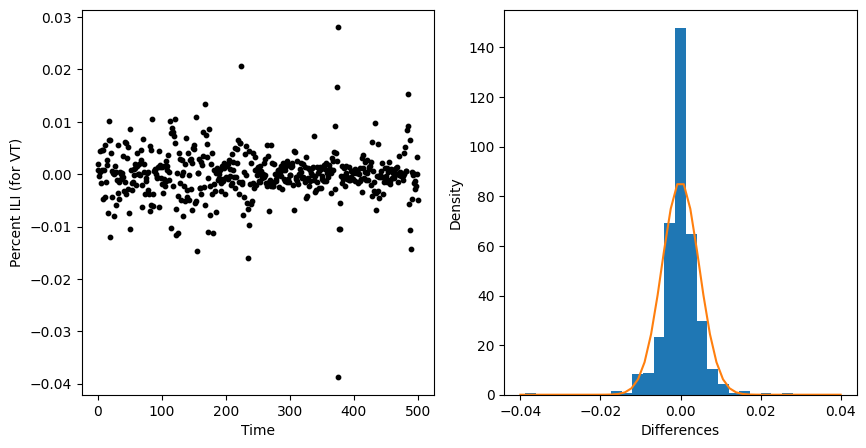

In [66]:
#--first we compute the differences
differences           = np.diff(ili_data["ili_prop"])
number_of_differences = len(differences)

#--setup a figure and axis to plot our data 
fig, axs = plt.subplots(1,2, figsize=(10,5))

##--Take the first axis for plotting a scatter of differences
ax=axs[0]
ax.scatter(np.arange(number_of_differences)
           , differences 
           , color = "black"
           , s     = 10)
ax.set_xlabel("Time")
ax.set_ylabel("Percent ILI (for VT)")

##--Take the second axis for plotting a histogram of differences
ax=axs[1]
ax.hist(x=differences,bins=25,density=True)

ax.set_xlabel("Differences")
ax.set_ylabel("Density")

#--Fit a normal curve with zero mean and estimated standard deviation 
import scipy.stats
estimated_std = np.std(differences)

domain = np.linspace(-0.04,0.04) 
pdf_values = scipy.stats.norm(0,estimated_std).pdf(domain )

plt.plot(domain, pdf_values)

plt.show()

## Forecasting with a random walk

Note that our specification for the random walk was 

\begin{align}
    x_{t} = x_{t-1} + \mathcal{N}(0,\sigma^{2}), 
\end{align}

but we didnt specify for what time units this model holds. 
Even more, we didnt specify how we will use this model to build a forecast.

A **forecast** is a sequence of probability distributions---often represented by random variables---over a sequence of future time units. 
Lets spend time better specifying our random walk model

\begin{align}
    x_{t} = x_{t-1} + \mathcal{N}(0,\sigma^{2}), 
\end{align}
for times $1,2,\cdots T$ where $T$ is the last observation from our time series data. 
We will generate a forecast for time units $T+1$ and so on as 

\begin{align}
    x_{T+1} &= x_{T} + \mathcal{N}(0,\sigma^{2})\\
    \\
    x_{T+2} &= x_{T+1} + \mathcal{N}(0,\sigma^{2})\\
    x_{T+2} &= x_{T} + \mathcal{N}(0,\sigma^{2}) +  \mathcal{N}(0,\sigma^{2})\\
\end{align}

Our random walk model generates a forecast at time $T+k$ by selecting the last observed value $x_{T}$ and adding $k$ draws from a Normal distribution centered at zero with standard deviation $\sigma^{2}$. 

Lets look at VT ILI data again and fit a random walk model. 
We will assume that we have observed the first 6 weeks (MMWRWK40-MMWRWK46) of the 2022/2023 season.
We will estimate the standard deviation of our differences (ie fitting the model) and we will generate a 5 week ahead forecast. 

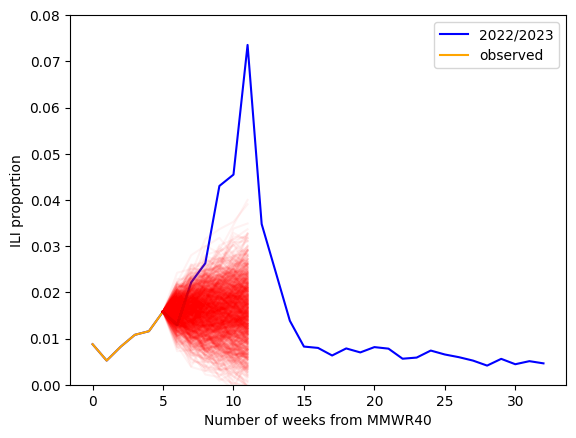

In [68]:
#--Aside: this adds season data to our ILI dataset
def add_season(row):
    from epiweeks import Week
    epiweek = str(row.epiweek)
    yr = int(epiweek[:4])
    wk = int(epiweek[-2:])

    w = Week(yr,wk)

    if w.week >=40:
        return "{:02d}/{:02d}".format( yr,yr+1 )
    elif w.week <=20:
        return "{:02d}/{:02d}".format( yr-1,yr )
    else:
        return "offseason" 
ili_data["season"] = [ add_season(row) for i,row in ili_data.iterrows()]

#--Lets select the 2022/2023 datset
one_season = ili_data.loc[ ili_data.season == "2022/2023" ]

#--extract the ILI proportion values
one_season_ili = one_season.ili_prop.values

#--assume that we only have information up to MMWRWK46
one_season_hidden = one_season_ili[:6]

#--visualize
fig,ax = plt.subplots()

#--plot the whole ILI curve 
ax.plot(one_season_ili, color = "blue", label = "2022/2023")

#--plot the observed curve up to MMWR46
ax.plot(one_season_hidden, label = "observed", color="orange")

#--Estimate the standard deviation of the differences (ie fit the model)
differences                  = np.diff(one_season_hidden)
estimated_standard_deviation = np.std(differences)

#--Generate our forecast
last_value = one_season_hidden[-1]
for sim in range(1000):
    rw = generate_random_walk(center = last_value, standard_deviation=estimated_standard_deviation, T=5)

    #--This is how you label just one curve for your legend
    ax.plot( np.arange(5,6+5+1), [last_value] + list(rw),color="red",alpha=0.05)

#--labels
ax.set_xlabel("Number of weeks from MMWR40")
ax.set_ylabel("ILI proportion")

ax.set_ylim(0,0.08)

#--add legend and show plot
ax.legend()
plt.show()

**What can we learn** from studying, and then fitting by hand, the random walk model?
The uncertainity in the random walk, and in many time series models, is characterized by the standard deviation.
So, we expect that for most time series models the standard deviation should depend on properties of our model (ie the random walk), how much data we collected (to better estimate our standard deviation), and, importantly, should depend on time.

In addition, we should be careful to specify how we fit our model to observed data and how we communicate to others the method we use to generate our forecasts. 

## AR(1): O, ive seen that in the past! Modeling a single time series. 

### Autocorrelation

A time series dataset is called auto-correlated if there exists a signficant correlation between: (1) subsequent values or (2) values at a regular interval. If a time series doesnt have any auto correlation for any regular time interval than this is a warning that your data may not be best modeled using time-series techniques. 
Without any auto-corrlelation, subsequent values are unlikely related to those values collected in the past. 
This will violate the assumptions more most if not all, time series models. 

How do we think of auto-correaltion using random variables? 
Let $X_{1},X_{2},\cdots,X_{T}$ represent the sequence of random variables that generated our time series. 
Then we may observe that values at one time point $x_{t}$ are not so different from the following value $x_{t+1}$.
This would imply that the random variables $X_{t}$ and $X_{t+1}$ are not statistically independent from one another. 

To understand the correlation between subsequent values, we can plot $x_{t+1}$ on the vertical axis and $x_{t}$ on the horizontal axis.
This is often called a lag 1-plot. 

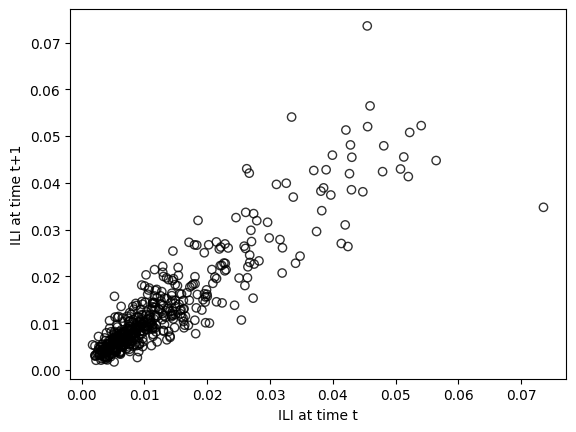

In [12]:
fig, ax = plt.subplots()

ili_prop = ili_data.ili_prop.values
ili_prop_at_tp1 = ili_prop[1:]
ili_prop_at_t   = ili_prop[:-1]

ax.scatter( ili_prop_at_t, ili_prop_at_tp1, alpha=0.80, edgecolors="black", facecolors="none")
ax.set_xlabel("ILI at time t")
ax.set_ylabel("ILI at time t+1")

plt.show()

We can see a very pronounced linear trend between ILI at time t and ILI and time t+1. 
We can quantify that correlation by computing the linear correlation coefficient. 

In [13]:
import numpy as np
LCC = np.corrcoef(ili_prop_at_t,ili_prop_at_tp1)[0,1]
print("Linear correlation for Lag 1 = {:.2f}".format(LCC))

Linear correlation for Lag 1 = 0.90


### The Auto-regressive model: leveraging the lag-1 plot

Given a sequence of observations $(x_{1},x_{2},x_{3},\cdots,x_{T})$ from a time-series, an auto-regressive one process [nicknamed AR(1)] assumes that the expected value at time $t+1$ has a linear relationship that depends on the observed value in the time series at time $t$. 
This linear relationship between the expected value at time $t+1$ and previously observed value cane be written mathematically as 

\begin{align}
    \mathbb{E}(x_{t+1}) = \beta_{0} + \beta_{1} x_{t}
\end{align}

where the symbol $\mathbb{E}$ is called the expected value.
The AR1 model also assumes a **Normal distribution** that is centered around this expected value 
$ \mathbb{E}(x_{t+1})$. 

```{note}
The Normal distribution is a distribution of non-surprisal, data close to the mean, or expectitude. 
The probability that we would find a value outside of two standard deviations from the expected value for a normal distribution is less than 5\%.
When a statistican or similar uses a Normal distribution with mean $\mu$ then you should think "ok, the statistician is communicating to me that the value is basically $\mu$"
```

The first way to write down the AR1 model is 

\begin{align}
x_{t+1} \mid \beta_{0},\beta_{1},x_t  &\sim \mathcal{N}\!\left( \overbrace{\beta_{0}+\beta_{1}x_t}^{\mu}\,,\ \sigma \right).
\end{align}

This says (1) i think that the distribution of values at $x_{t+1}$ looks like a bell-curve (Normal) (2) i think that this next value is quite close to $\beta_{0}+\beta_{1}x_t$, and (3) i think that this next value depends on $x_{t}$. 
An alternative way to write down this model focuses more on the expected value, 

\begin{align}
    x_{t+1} &= \overbrace{\beta_{0} + \beta_{1} x_{t}}^{\mu} + \epsilon_{t}\\
    \epsilon_{t} &\sim \mathcal{N}(0,\sigma)
\end{align}

### Fitting the model and inspecting our model realism




In [14]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(ili_data.ili_prop.values, 1).fit()
model.summary()

#np.polyfit(ili_data.ili_prop.values[:-1],ili_data.ili_prop.values[1:],1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  502
Model:                     AutoReg(1)   Log Likelihood                1994.834
Method:               Conditional MLE   S.D. of innovations              0.005
Date:                Tue, 14 Oct 2025   AIC                          -3983.669
Time:                        21:57:39   BIC                          -3971.019
Sample:                             1   HQIC                         -3978.706
                                  502                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      3.970      0.000       0.001       0.002
y.L1           0.9035      0.019     47.444      0.000       0.866       0.941
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1068           +0.0000j            1.1068            0.0000
-----------------------------------------------------------------------------
"""

#### Seasonality

Another noticeable feature of our ILI time series is the repeated pattern of values, and all of us have likely observed the seasonal pattern of ILI. 
In statistical literature this too is called `seasonality'.
A time series is "seasonal" at time interval $V$ if there exists a correlation between values spaced $V$ units apart.

We can gain an understanding of seasonality, and correlations at all time intervals, by building an **auto-correlation plot**. 
An auto correlation plot is produced by repeating the following two steps.
1. For time interval $V$
    1. Assign the variable $D_1$ the dataset (x_{1},x_{2},\cdots,x_{T-v}) and the variable $D_{2}$ the dataset (x_{v},x_{v+1},\cdots,x_{T})
    2. Compute the linear correlaiton coefficient and call it corr
    3. Plot the point (V,corr)

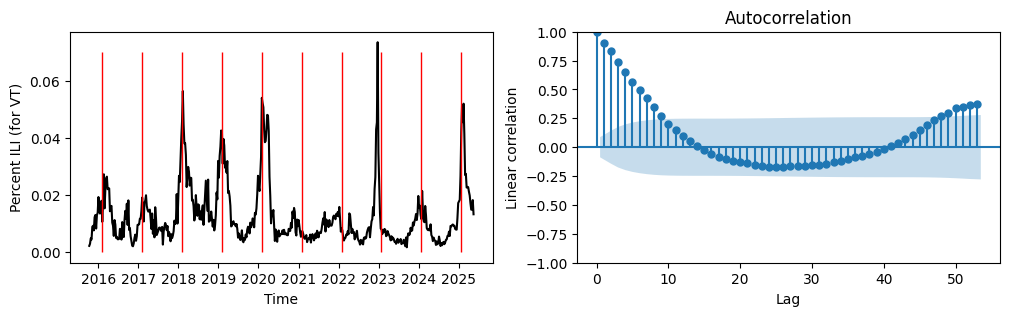

In [15]:
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf

fig,axs = plt.subplots(1,2, figsize=(12,3))
ax      = axs[0]
ax.plot( ili_data["end_date"], ili_data["ili_prop"], color = "black" )
ax.set_xlabel("Time")
ax.set_ylabel("Percent ILI (for VT)")

markers = 17+np.arange(0,len(ili_data),52)
ax.vlines(x=ili_data["end_date"][markers]
          ,ymin=[0]*len(markers)
          ,ymax = [0.07]*len(markers)
          , lw=1
          , color="red")

ax=axs[1]
plot_acf(ili_data.ili_prop.values, lags = 53,ax=ax)
ax.set_xlabel("Lag")
ax.set_ylabel("Linear correlation")

plt.show()

## SAR: What comes around goes around. Modeling a stack of time series (and a look at the CDC baseline model)  

## Whats the deal with MA? 

## The I in ARIMA: One way to handle a trend in your time series data

## What do we mean when we fit a compartmental model? 